In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.relpath("../../../ms-bgd-2018-fil-rouge/libutil"))
from util import get_full_df_with_stops

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

In [3]:
def convert_outliers_to_nan(df):
    if 'P_avg' in df.columns:
        df.loc[(df.P_avg > 10000) | (df.P_avg < 0.01), 'P_avg'] = np.nan
    if 'Ws_avg' in df.columns:
        # + clean: : is.frozen(.data[['Ws']])
        df.loc[(df.Ws_avg > 30) | (df.Ws_avg < 0), 'Ws_avg'] = np.nan
    if 'Na_c_avg' in df.columns:
        df.loc[(df.Na_c_avg == 0), 'Na_c_avg'] = np.nan
    if 'Rs_avg' in df.columns:
        df.loc[(df.Rs_avg < 0) | (df.Rs_avg > 40), 'Rs_avg'] = np.nan
    if 'Ds_avg' in df.columns:
        df.loc[(df.Ds_avg < 0), 'Ds_avg'] = np.nan
    if 'Ba_avg' in df.columns:
        df.loc[(df.Ba_avg > 100), 'Ba_avg'] = np.nan
    if 'Ot_avg' in df.columns:
        df.loc[(df.Ot_avg > 50) | (df.Ot_avg < -20) | (df.Ot_avg == 0),
               'Ot_avg'] = np.nan  # + clean: : is.frozen(.data[["Ot"]])
    if 'Rbt_avg' in df.columns:
        df.loc[(df.Rbt_avg > 150), 'Rbt_avg'] = np.nan

In [4]:
data_and_stops = get_full_df_with_stops(removestops=True).sort_index(level=[1, 0])  # ordre chronologique
data_and_stops = data_and_stops[(data_and_stops.index.get_level_values(1) >= '2012') & (data_and_stops.index.get_level_values(1) < '2017')]
data_and_stops.head()

,,Ba_avg,Cm_avg,Cosphi_avg,DCs_avg,Db1t_avg,Db2t_avg,Ds_avg,Dst_avg,Gb1t_avg,Gb2t_avg,...,Yt_avg,endTs,dateB,dateE,duration_hr,group,groupeExploitation,stop,dateNextBreak,daysToNextBreak
Wind_turbine_name,datetime,,,,,,,,,,,,,,,,,,,,,
R80711,2012-01-01 00:00:00+01:00,-0.73,6296.5898,1.00,1793.25,40.939999,36.950001,1791.85,64.980003,66.940002,71.440002,...,18.450001,2012-01-01 00:10:00+01:00,NaT,NaT,NaN,NaN,NaN,0.0,2012-02-07 07:20:00+01:00,37.305556
R80721,2012-01-01 00:00:00+01:00,-0.95,5281.1401,1.00,1761.66,54.880001,35.730000,1765.77,60.580002,75.160004,70.779999,...,24.070000,2012-01-01 00:10:00+01:00,NaT,NaT,NaN,NaN,NaN,0.0,2012-09-13 11:40:00+02:00,256.444444
R80736,2012-01-01 00:00:00+01:00,-0.99,3685.0500,0.99,1673.97,42.400002,35.500000,1671.14,62.599998,66.129997,71.230003,...,25.620001,2012-01-01 00:10:00+01:00,NaT,NaT,NaN,NaN,NaN,0.0,2012-01-07 15:20:00+01:00,6.638889
R80790,2012-01-01 00:00:00+01:00,-1.00,5562.8501,1.00,1787.27,41.360001,40.570000,1789.52,63.810001,64.970001,72.110001,...,20.480000,2012-01-01 00:10:00+01:00,NaT,NaT,NaN,NaN,NaN,0.0,2012-01-19 05:40:00+01:00,18.236111
R80711,2012-01-01 00:10:00+01:00,-0.95,5771.9800,1.00,1781.72,38.110001,35.610001,1780.33,62.619999,64.949997,70.639999,...,17.200001,2012-01-01 00:20:00+01:00,NaT,NaT,NaN,NaN,NaN,0.0,2012-02-07 07:20:00+01:00,37.298611


In [5]:
var = ['Ba_avg', 'Ws_avg', 'P_avg', 'Rs_avg', 'Dst_avg', 'Gost_avg', 'Rbt_avg', 'Yt_avg']

dic = {'Ba_avg': 'Pitch [deg]', 'Wa_c_avg': 'Wind dir. [deg]', 'Na_c_avg': 'Yaw [deg]', 'Ws_avg': 'Wind speed [m/s]', 'P_avg': 'Active power [kW]', 'Cm_avg': 'Conv. torque [Nm]', 'Rm_avg': 'Torque [Nm]', 'DCs_avg': 'Gen. conv. speed [rpm]', 'Ds_avg': 'Gen. speed [rpm]', 'Rs_avg': 'Rotor speed [rpm]', 'Q_avg': 'Reactive power [kW]',
       'Db1t_avg': 'Gen. bear. temp. [degC]', 'Dst_avg': 'Gen. stator temp. [degC]', 'Gb1t_avg': 'Gbox bear. temp. [degC]', 'Git_avg': 'Gbox inlet temp. [degC]', 'Gost_avg': 'Gbox oil sump temp. [degC]', 'Rbt_avg': 'Rotor bear. temp. [degC]', 'Rt_avg': 'Hub temp. [degC]', 'Yt_avg': 'Nacelle temp. [degC]', 'Ot_avg': 'Outdoor temp. [degC]', 'Nf_avg': 'Grid freq. [Hz]', 'Nu_avg': 'Grid voltage [V]'}

# Remove outliers (lots of negative power values?)
convert_outliers_to_nan(data_and_stops)
# Drop any lines with NaN
data_and_stops.dropna(axis=0, how='any', inplace=True, subset=var)

In [6]:
test_size = 0.1
l = int((1 - test_size) * data_and_stops.shape[0])

scaler = StandardScaler()
training = scaler.fit_transform(data_and_stops.iloc[:l][var])
test = scaler.transform(data_and_stops.iloc[l:][var])

In [7]:
clf = IsolationForest(n_estimators=100, max_samples=0.05,
                      random_state=rng, n_jobs=-1)
clf.fit(training)
scores_train = clf.decision_function(training)
scores_test = clf.decision_function(test)

thr = np.percentile(scores_train, 0.2)
print(thr)

-0.1000599665852665


In [8]:
df = data_and_stops.iloc[l:][var].copy()
df.columns = [s.split('_')[0] for s in df.columns]
df['normal'] = (scores_test > thr)
df.head()

,,Ba,Ws,P,Rs,Dst,Gost,Rbt,Yt,normal
Wind_turbine_name,datetime,,,,,,,,,
R80711,2016-06-30 09:40:00+02:00,-0.97,5.31,167.72000,11.16,65.139999,57.270000,30.730000,28.280001,True
R80721,2016-06-30 09:40:00+02:00,-1.00,5.76,217.06000,12.04,63.009998,56.939999,34.279999,33.930000,True
R80736,2016-06-30 09:40:00+02:00,-0.99,6.26,335.50000,13.63,64.379997,56.869999,33.549999,32.320000,True
R80790,2016-06-30 09:40:00+02:00,-0.99,5.87,223.62000,12.04,57.799999,56.049999,35.650002,25.290001,True
R80711,2016-06-30 09:50:00+02:00,-0.97,5.70,176.10001,11.43,63.459999,55.950001,30.440001,24.170000,True


In [9]:
def myfun(null_value=None):
    """
    Returns list of 44 1-month dataframes (6-month data of 4 turbines with overlap=0.5)
    """
    
    list_df = []
    n_samples = 4320  # 30 days @ 10 min step
    datetime = pd.date_range(freq='10min', start='2018-05-01', periods=n_samples)    
    # datetime = [d.strftime('%b %d %H:%M') for d in datetime]
    
    turbines = data_and_stops.index.get_level_values(0).unique().tolist()
    
    for turbine in turbines:
        df_turbine = df.loc[turbine].resample('10min').mean()
        df_turbine['index'] = df_turbine['normal'].rolling(12, min_periods=6).mean()
        if null_value is not None:
            df_turbine['index'].fillna(null_value, inplace=True)

        fig, ax = plt.subplots()
        df_turbine['index'].plot(ax=ax)
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        
        for i in range(0, 11):
            temp = df_turbine[i*n_samples//2:(i+2)*n_samples//2].reset_index()
            temp['datetime'] = datetime
            temp.insert(0, 'name', '{}-{:02d}'.format(turbine, i))
            list_df.append(temp)
        
    return list_df

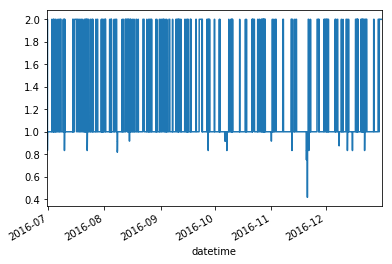

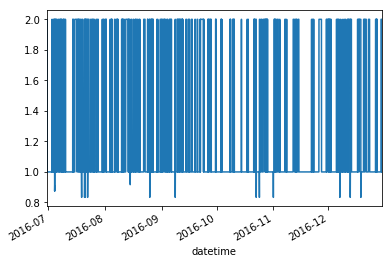

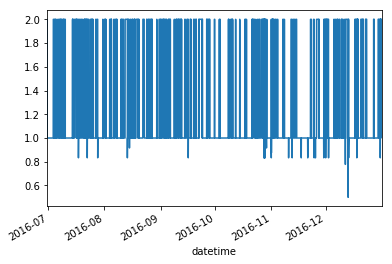

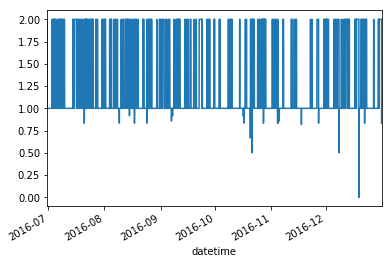

In [10]:
list_df = myfun(null_value=2.0)

In [11]:
list_df[0].head()

,name,datetime,Ba,Ws,P,Rs,Dst,Gost,Rbt,Yt,normal,index
0,R80711-00,2018-05-01 00:00:00,-0.97,5.31,167.72000,11.16,65.139999,57.270000,30.730000,28.280001,1.0,2.0
1,R80711-00,2018-05-01 00:10:00,-0.97,5.70,176.10001,11.43,63.459999,55.950001,30.440001,24.170000,1.0,2.0
2,R80711-00,2018-05-01 00:20:00,-0.99,6.34,349.07999,13.77,60.520000,55.279999,30.230000,23.090000,1.0,2.0
3,R80711-00,2018-05-01 00:30:00,-0.99,6.00,254.14999,12.56,57.759998,55.700001,30.150000,22.600000,1.0,2.0
4,R80711-00,2018-05-01 00:40:00,-0.99,6.62,347.64999,13.78,55.349998,57.200001,30.110001,23.180000,1.0,2.0


In [12]:
dic = {'parc1': pd.concat(list_df), 'parc2': pd.concat(
    list_df[:22]), 'parc3': pd.concat(list_df[22:33]), 'parc4': pd.concat(list_df[33:])}

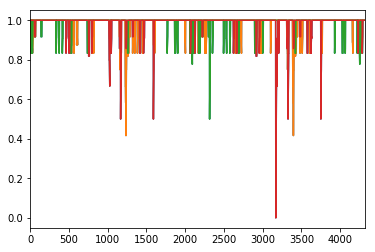

In [13]:
list_df = []
for parc in dic.keys():
    temp = dic[parc].groupby('datetime')[['index']].min().reset_index()
    temp.insert(0, 'name', parc)

    temp['index'].plot()

    list_df.append(temp)

parcs = pd.concat(list_df)

In [14]:
for parc in dic.keys():
    dic[parc].to_json(path_or_buf=parc + ".json", orient='records')

parcs.to_json(path_or_buf="parcs.json", orient='records')